In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM as tp_lc_functions

In [2]:
# Using the 0D TNG100 SIM data at z=0 (version 6 of the dataset that includes Mvir in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v6_TNG-SIM_0D_Dataset_wMvir.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

def log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' not in feature:
            df.loc[:, feature + '_log']=df.loc[:,feature].apply(lambda x: np.log10(x + 1.e-8))
            df.drop(columns = [feature], inplace = True)
#             print(df.loc[:, feature])
        else:continue
        
    return df

df_raw_log = log_df(df_raw)

print('df_raw_log.shape', df_raw_log.shape)

df_0D_log = log_df(df_0D)

print('df_0D_log.shape', df_0D_log.shape)

df_0D.shape (21598, 17)
df_raw.shape (21598, 19)
df_raw_log.shape (21598, 19)
df_0D_log.shape (21598, 17)


## <font color='purple'> <a id =10> </a> <br> Complete  Dataset w DM features only

## Raw Dataset: RF & SVR

In [57]:
# RF and SVR predicted log10Rstar
y_pred_RF_dm = pd.read_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_wDMfeatures_y_pred_RF_predicted_sizes.csv')
y_pred_SVR_dm = pd.read_csv('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_wDMfeatures_y_pred_SVR_predicted_sizes.csv')

# RF and SVR predicted Rstar, and true Rstar

y_pred_RF = 10**(y_pred_RF_dm)
y_true = df_raw.loc[:, 'SubhaloRstar']
print(y_pred_RF.shape)
print(y_true.shape)

y_pred_SVR = 10**(y_pred_SVR_dm)
print(y_pred_SVR.shape)

# Make a df with pred_true values to use w seaborn

df_pred_true = pd.DataFrame({'y_pred_RF' : y_pred_RF.loc[:, 'y_pred_RF SIM Raw'], 
                             'y_pred_SVR': y_pred_SVR.loc[:, 'y_pred_SVR SIM Raw'],
                             'y_true' : df_raw.loc[:, 'SubhaloRstar']})

(21598, 1)
(21598,)
(21598, 1)


In [58]:
df_pred_true

,y_pred_RF,y_pred_SVR,y_true
0,57.299833,84.791765,67.312584
1,47.981112,51.351102,125.480890
2,37.914745,46.352180,82.916380
3,51.447799,50.071341,28.387566
4,55.446718,56.921964,50.823353
...,...,...,...
21593,3.421130,3.499931,3.610431
21594,3.636734,3.746822,3.105893
21595,3.523101,3.409124,4.197745
21596,3.691570,4.351040,2.867348


In [25]:
r2_RF_dm = np.round(r2_score(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_RF_dm.loc[:,'y_pred_RF SIM Raw'])), 2)
print('r2 dm', r2_RF_dm)
r2_SVR_dm = np.round(r2_score(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_SVR_dm.loc[:,'y_pred_SVR SIM Raw'])), 2)
print('r2 SVR dm', r2_SVR_dm)
mape_RF_dm = mean_absolute_percentage_error(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_RF_dm.loc[:,'y_pred_RF SIM Raw']))
mape_SVR_dm = mean_absolute_percentage_error(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_SVR_dm.loc[:,'y_pred_SVR SIM Raw']))
print('mape RF', mape_RF_dm )
print('mape SVR', mape_SVR_dm )
print('RF Original var r2 score:', r2_score(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_RF_dm.loc[:,'y_pred_RF SIM Raw'])))
print('SVR Original var r2 score:', r2_score(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_SVR_dm.loc[:,'y_pred_SVR SIM Raw'])))

r2 dm 0.66
r2 SVR dm 0.67
mape RF 0.2889826907635649
mape SVR 0.29143320737420075
RF Original var r2 score: 0.6638971073944903
SVR Original var r2 score: 0.6747679295731455


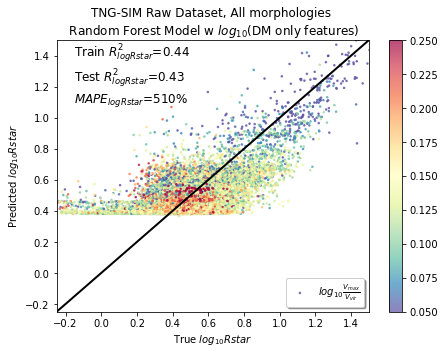

In [9]:
# Plot of Predicted log10 Raw Rstar vs True log 10 Raw Rstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloRstar_log, y_pred_RF_dm,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.44' + '\n' + r'Test $R^{2}_{logRstar}$=0.43' + '\n' + r'$MAPE_{logRstar}$=510$\%$ ', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, All morphologies \n ' + r'Random Forest Model w $log_{10}$(DM only features) ')
ax.set_xlabel(r'True $log_{10}Rstar$')
ax.set_ylabel(r'Predicted $log_{10}Rstar$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_wDMfeatures_RF_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

In [53]:
RF_pred_true = pd.DataFrame({'y_pred_RF' : y_pred_RF.loc[:, 'y_pred_RF SIM Raw'], 'y_true' : df_raw.loc[:, 'SubhaloRstar']})

In [54]:
RF_pred_true

,y_pred_RF,y_true
0,57.299833,67.312584
1,47.981112,125.480890
2,37.914745,82.916380
3,51.447799,28.387566
4,55.446718,50.823353
...,...,...
21593,3.421130,3.610431
21594,3.636734,3.105893
21595,3.523101,4.197745
21596,3.691570,2.867348


In [48]:
y_pred_RF.loc[:, 'y_pred_RF SIM Raw']

0        57.299833
1        47.981112
2        37.914745
3        51.447799
4        55.446718
           ...    
21593     3.421130
21594     3.636734
21595     3.523101
21596     3.691570
21597     3.421130
Name: y_pred_RF SIM Raw, Length: 21598, dtype: float64

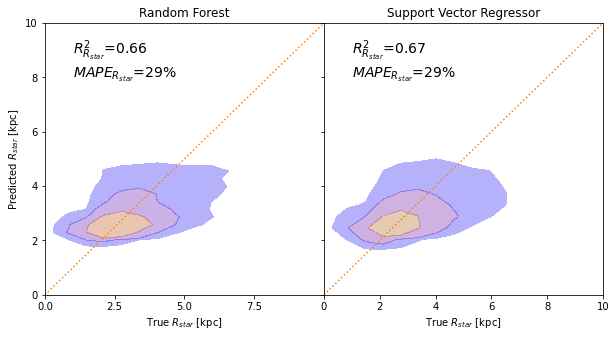

In [77]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
# fig.suptitle(r'TNG-SIM Central Galaxies: Predicted vs True $R_{star}$ ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = (r'$R^{2}$={}' + '\n' + r'$MAPE_{Rstar}$={}$\%$'.format(r2_RF_dm, mape_RF_dm))
# label = r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im1 = ax1.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_dm), 
#                     s=3, marker='.', alpha=0.7, label=label) # , vmin=-2, vmax=1.0)

im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_RF', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax1, fill=True, cmap='brg',
                 legend = r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$')
# ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([0.0, 2.5, 5.0, 7.5]) #, 10.0 ]) #, 12.5, 15.0, 17.5])
# ax1.set_ylim([-0.5,2.0])
ax1.axis([0.0,10.0, 0.0,10.0])
ax1.set_title('Random Forest', fontsize=15)
ax1.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax1.set_ylabel(r'Predicted $R_{star}$ [kpc]', fontsize=15)
ax1.annotate(r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax1.legend(loc='upper left', shadow=True)
ax1.plot([0, 30], [0, 30],linestyle='dotted')

# label = r'$R^{2}_{R_{star}}$=0.67'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im2 = ax2.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_dm), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_SVR', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax2, fill=True, cmap='brg') #,
#                  label = label, legend=True)
# ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.axis([0.0,10.0, 0.0,10.0])
ax2.set_title('Support Vector Regressor', fontsize=15)
ax2.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax2.annotate(r'$R^{2}_{R_{star}}$=0.67'+'\n'+r'$MAPE_{R_{star}}$=29$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax2.set_ylabel(r'Predicted $R_{star}$ [kpc]')
# ax2.legend(loc='upper left' , shadow=True)
ax2.plot([0, 30], [0, 30],linestyle='dotted')

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v26_fig_RF_SVR_DMfeaturesonly/v26_DMfeaturesonly_TNG-SIM_RF_SVR_pred_true_KDEnotitle.pdf", dpi=500)
plt.show()

## 0D + Mvir Dataset: RF & SVR

In [16]:
# RF and SVR predicted log10Rstar


y_pred_RF_dm_0D = pd.read_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_wDMfeatures_AllDatasetwMvir_y_pred_RF_predicted_sizes.csv')
y_pred_SVR_dm_0D = pd.read_csv('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_wDMfeatures_AllDatasetwMvir_y_pred_SVRwepsilon_predicted_sizes_2.csv')

# Solving the indexing problem of the two dataframes
y_pred_RF_dm_0D_copy = y_pred_RF_dm_0D.copy()

df_raw_copy = df_raw.copy()

df_raw_copy.reset_index(inplace=True)

y_pred_RF_dm_0D_copy.reset_index(inplace=True)

y_pred_SVR_dm_0D_copy = y_pred_SVR_dm_0D.copy()
y_pred_SVR_dm_0D_copy.reset_index(inplace=True)

# RF and SVR predicted Rstar, and true Rstar

y_pred_RF = (10**(y_pred_RF_dm_0D_copy.loc[:, 'y_pred_RF SIM 0D']- 1.e-8))*df_raw_copy.loc[:, 'Group_R_TopHat200']
y_true = df_raw.loc[:, 'SubhaloRstar']
print(y_pred_RF.shape)
print(y_true.shape)

y_pred_SVR = (10**(y_pred_SVR_dm_0D_copy.loc[:, 'y_pred_SVR SIM 0D']- 1.e-8))*df_raw_copy.loc[:, 'Group_R_TopHat200']
print(y_pred_SVR.shape)

(21598,)
(21598,)
(21598,)


In [22]:
# Make a df with pred_true values to use w seaborn

df_pred_true = pd.DataFrame({'y_pred_RF' : y_pred_RF, 
                             'y_pred_SVR': y_pred_SVR,
                             'y_true' : df_raw.loc[:, 'SubhaloRstar']})

In [23]:
df_pred_true

,y_pred_RF,y_pred_SVR,y_true
0,64.715907,57.535191,67.312584
1,61.551926,56.821040,125.480890
2,45.849817,45.854552,82.916380
3,42.858200,48.647465,28.387566
4,47.966562,55.604202,50.823353
...,...,...,...
21593,3.398761,2.913324,3.610431
21594,3.017851,2.712877,3.105893
21595,3.245742,2.584137,4.197745
21596,3.034378,2.360106,2.867348


In [24]:
r2_RF_dm = np.round(r2_score(y_true, y_pred_RF), 2)
print('r2 dm', r2_RF_dm)
r2_SVR_dm = np.round(r2_score(y_true, y_pred_SVR), 2)
print('r2 SVR dm', r2_SVR_dm)
mape_RF_dm = mean_absolute_percentage_error(y_true, y_pred_RF)
mape_SVR_dm = mean_absolute_percentage_error(y_true, y_pred_SVR)
print('mape RF', mape_RF_dm )
print('mape SVR', mape_SVR_dm )

r2 dm 0.69
r2 SVR dm 0.69
mape RF 0.289246408877145
mape SVR 0.2911806420770462


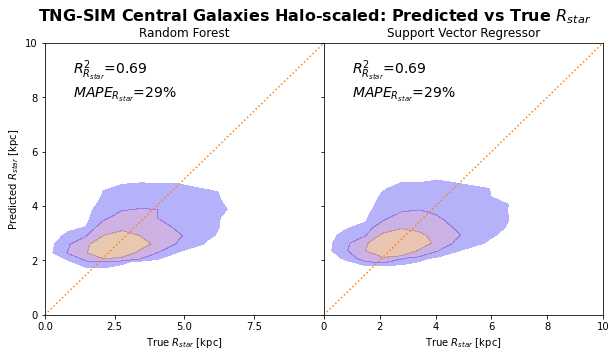

In [41]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle(r'TNG-SIM Central Galaxies Halo-scaled: Predicted vs True $R_{star}$ ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = (r'$R^{2}$={}' + '\n' + r'$MAPE_{Rstar}$={}$\%$'.format(r2_RF_dm, mape_RF_dm))
# label = r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im1 = ax1.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_dm), 
#                     s=3, marker='.', alpha=0.7, label=label) # , vmin=-2, vmax=1.0)

im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_RF', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax1, fill=True, cmap='brg') #,
#                  legend = r'$R^{2}_{R_{star}}$=0.69'+'\n'+r'$MAPE_{R_{star}}$=29$\%$')
# ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([0.0, 2.5, 5.0, 7.5]) #, 10.0 ]) #, 12.5, 15.0, 17.5])
# ax1.set_ylim([-0.5,2.0])
ax1.axis([0.0,10.0, 0.0,10.0])
ax1.set_title('Random Forest', fontsize=15)
ax1.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax1.set_ylabel(r'Predicted $R_{star}$ [kpc]', fontsize=15)
ax1.annotate(r'$R^{2}_{R_{star}}$=0.69'+'\n'+r'$MAPE_{R_{star}}$=29$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax1.legend(loc='upper left', shadow=True)
ax1.plot([0, 30], [0, 30],linestyle='dotted')

# label = r'$R^{2}_{R_{star}}$=0.67'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im2 = ax2.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_dm), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_SVR', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax2, fill=True, cmap='brg') #,
#                  label = label, legend=True)
# ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.axis([0.0,10.0, 0.0,10.0])
ax2.set_title('Support Vector Regressor', fontsize=15)
ax2.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax2.annotate(r'$R^{2}_{R_{star}}$=0.69'+'\n'+r'$MAPE_{R_{star}}$=29$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax2.set_ylabel(r'Predicted $R_{star}$ [kpc]')
# ax2.legend(loc='upper left' , shadow=True)
ax2.plot([0, 30], [0, 30],linestyle='dotted')

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v26_fig_RF_SVR_DMfeaturesonly/v26_DMfeaturesonly0D_TNG-SIM_RF_SVR_pred_true_KDE.pdf", dpi=500)
plt.show()

## <font color='purple'> <a id =10> </a> <br> Complete  Dataset w all features 

In [45]:
import os 
# os.mkdir('TNG-SIM_images/v26_fig_RF_SVR_allfeatures')

### <font color='purple'> <a id =10> </a> <br> Complete Raw Dataset w all features

In [56]:
# RF and SVR predicted log10Rstar
y_pred_RF_all = pd.read_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_y_pred_RF_predicted_sizes.csv')

y_pred_SVR_all = pd.read_csv('TNG-SIM_images/v16_SVR/v16_TNG-SIM_Raw_AllDataset_y_pred_SVRwepsilon_predicted_sizes.csv')

# RF and SVR predicted Rstar, and true Rstar

y_pred_RF = 10**(y_pred_RF_all)
y_true = df_raw.loc[:, 'SubhaloRstar']
print(y_pred_RF.shape)
print(y_true.shape)

y_pred_SVR = 10**(y_pred_SVR_all)
print(y_pred_SVR.shape)

# Make a df with pred_true values to use w seaborn

df_pred_true = pd.DataFrame({'y_pred_RF' : y_pred_RF.loc[:, 'y_pred_RF SIM Raw'], 
                             'y_pred_SVR': y_pred_SVR.loc[:, 'y_pred_SVR SIM Raw'],
                             'y_true' : df_raw.loc[:, 'SubhaloRstar']})

(21598, 1)
(21598,)
(21598, 1)


In [57]:
df_pred_true

,y_pred_RF,y_pred_SVR,y_true
0,53.018283,48.302214,67.312584
1,51.454145,70.500778,125.480890
2,46.844442,60.354697,82.916380
3,47.948878,26.818258,28.387566
4,53.852822,57.327824,50.823353
...,...,...,...
21593,3.485951,3.753195,3.610431
21594,2.255400,3.136037,3.105893
21595,3.364624,3.369408,4.197745
21596,2.711418,2.379035,2.867348


In [58]:
r2_RF_all = np.round(r2_score(y_true, y_pred_RF), 2)
print('r2 RF ', r2_RF_all)
r2_SVR_all = np.round(r2_score(y_true, y_pred_SVR), 2)
print('r2 SVR ', r2_SVR_all)
mape_RF_all = mean_absolute_percentage_error(y_true, y_pred_RF)
mape_SVR_all = mean_absolute_percentage_error(y_true, y_pred_SVR)
print('mape RF', mape_RF_all )
print('mape SVR', mape_SVR_all )

r2 RF  0.85
r2 SVR  0.89
mape RF 0.12413518160577472
mape SVR 0.10657973054810208


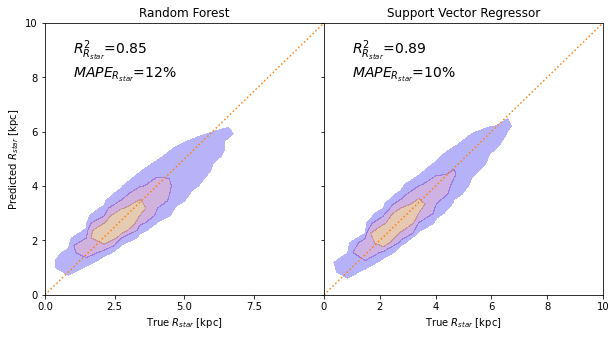

In [60]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
# fig.suptitle(r'TNG-SIM Central Galaxies w all features: Predicted vs True $R_{star}$ ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = (r'$R^{2}$={}' + '\n' + r'$MAPE_{Rstar}$={}$\%$'.format(r2_RF_dm, mape_RF_dm))
# label = r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im1 = ax1.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_dm), 
#                     s=3, marker='.', alpha=0.7, label=label) # , vmin=-2, vmax=1.0)

im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_RF', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax1, fill=True, cmap='brg') #,
#                  legend = r'$R^{2}_{R_{star}}$=0.85'+'\n'+r'$MAPE_{R_{star}}$=12$\%$')
# ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([0.0, 2.5, 5.0, 7.5]) #, 10.0 ]) #, 12.5, 15.0, 17.5])
# ax1.set_ylim([-0.5,2.0])
ax1.axis([0.0,10.0, 0.0,10.0])
ax1.set_title('Random Forest', fontsize=15)
ax1.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax1.set_ylabel(r'Predicted $R_{star}$ [kpc]', fontsize=15)
ax1.annotate(r'$R^{2}_{R_{star}}$=0.85'+'\n'+r'$MAPE_{R_{star}}$=12$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax1.legend(loc='upper left', shadow=True)
ax1.plot([0, 30], [0, 30],linestyle='dotted')

# label = r'$R^{2}_{R_{star}}$=0.67'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im2 = ax2.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_dm), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_SVR', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax2, fill=True, cmap='brg') #,
#                  label = label, legend=True)
# ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.axis([0.0,10.0, 0.0,10.0])
ax2.set_title('Support Vector Regressor', fontsize=15)
ax2.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax2.annotate(r'$R^{2}_{R_{star}}$=0.89'+'\n'+r'$MAPE_{R_{star}}$=10$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax2.set_ylabel(r'Predicted $R_{star}$ [kpc]')
# ax2.legend(loc='upper left' , shadow=True)
ax2.plot([0, 30], [0, 30],linestyle='dotted')

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v26_fig_RF_SVR_allfeatures/v26_allfeatures_TNG-SIM_RF_SVR_pred_true_KDEnotitle.pdf", dpi=500)
plt.show()

### <font color='purple'> <a id =10> </a> <br> Complete 0D+Mvir Dataset w all features

In [49]:
# RF and SVR predicted log10Rstar


y_pred_RF_all_0D = pd.read_csv('TNG-SIM_images/v19_RF_FeatRank_0D/v19_TNG-SIM_0D_AllDatasetwMvir_y_pred_RF_predicted_sizes.csv')

y_pred_SVR_all_0D = pd.read_csv('TNG-SIM_images/v20_SVR_0D/v20_TNG-SIM_0D_AllDatasetwMvir_y_pred_SVRwepsilon_predicted_sizes_2.csv')

# Solving the indexing problem of the two dataframes
y_pred_RF_all_0D_copy = y_pred_RF_all_0D.copy()

df_raw_copy = df_raw.copy()

df_raw_copy.reset_index(inplace=True)

y_pred_RF_all_0D_copy.reset_index(inplace=True)

y_pred_SVR_all_0D_copy = y_pred_SVR_all_0D.copy()
y_pred_SVR_all_0D_copy.reset_index(inplace=True)

# RF and SVR predicted Rstar, and true Rstar

y_pred_RF = (10**(y_pred_RF_all_0D_copy.loc[:, 'y_pred_RF SIM 0D']- 1.e-8))*df_raw_copy.loc[:, 'Group_R_TopHat200']
y_true = df_raw.loc[:, 'SubhaloRstar']
print(y_pred_RF.shape)
print(y_true.shape)

y_pred_SVR = (10**(y_pred_SVR_all_0D_copy.loc[:, 'y_pred_SVR SIM 0D']- 1.e-8))*df_raw_copy.loc[:, 'Group_R_TopHat200']
print(y_pred_SVR.shape)

(21598,)
(21598,)
(21598,)


In [50]:
# Make a df with pred_true values to use w seaborn

df_pred_true = pd.DataFrame({'y_pred_RF' : y_pred_RF, 
                             'y_pred_SVR': y_pred_SVR,
                             'y_true' : df_raw.loc[:, 'SubhaloRstar']})

In [51]:
df_pred_true 

,y_pred_RF,y_pred_SVR,y_true
0,48.704810,50.614363,67.312584
1,60.644085,99.105903,125.480890
2,48.819457,57.967569,82.916380
3,28.909879,34.370106,28.387566
4,47.072241,67.694479,50.823353
...,...,...,...
21593,3.469437,3.942099,3.610431
21594,2.809254,2.376600,3.105893
21595,3.266918,3.264565,4.197745
21596,2.905767,2.712184,2.867348


In [52]:
r2_RF_all = np.round(r2_score(y_true, y_pred_RF), 2)
print('r2 RF ', r2_RF_all)
r2_SVR_all = np.round(r2_score(y_true, y_pred_SVR), 2)
print('r2 SVR ', r2_SVR_all)
mape_RF_all = mean_absolute_percentage_error(y_true, y_pred_RF)
mape_SVR_all = mean_absolute_percentage_error(y_true, y_pred_SVR)
print('mape RF', mape_RF_all )
print('mape SVR', mape_SVR_all )

r2 RF  0.86
r2 SVR  0.91
mape RF 0.1279046873098344
mape SVR 0.10731528328693471


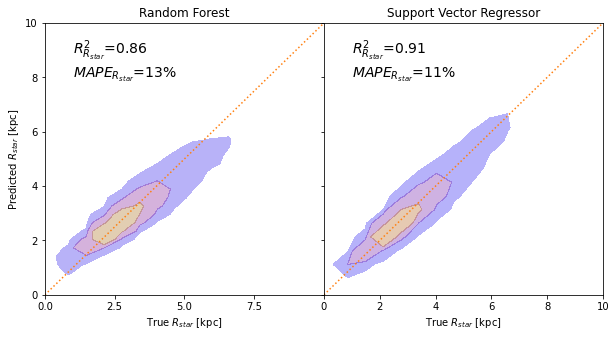

In [55]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
# fig.suptitle(r'TNG-SIM Central Galaxies Halo-scaled w all features: Pred vs True $R_{star}$ ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = (r'$R^{2}$={}' + '\n' + r'$MAPE_{Rstar}$={}$\%$'.format(r2_RF_dm, mape_RF_dm))
# label = r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im1 = ax1.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_dm), 
#                     s=3, marker='.', alpha=0.7, label=label) # , vmin=-2, vmax=1.0)

im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_RF', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax1, fill=True, cmap='brg') #,
#                  legend = r'$R^{2}_{R_{star}}$=0.69'+'\n'+r'$MAPE_{R_{star}}$=29$\%$')
# ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([0.0, 2.5, 5.0, 7.5]) #, 10.0 ]) #, 12.5, 15.0, 17.5])
# ax1.set_ylim([-0.5,2.0])
ax1.axis([0.0,10.0, 0.0,10.0])
ax1.set_title('Random Forest', fontsize=15)
ax1.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax1.set_ylabel(r'Predicted $R_{star}$ [kpc]', fontsize=15)
ax1.annotate(r'$R^{2}_{R_{star}}$=0.86'+'\n'+r'$MAPE_{R_{star}}$=13$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax1.legend(loc='upper left', shadow=True)
ax1.plot([0, 30], [0, 30],linestyle='dotted')

# label = r'$R^{2}_{R_{star}}$=0.67'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im2 = ax2.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_dm), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_SVR', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax2, fill=True, cmap='brg') #,
#                  label = label, legend=True)
# ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.axis([0.0,10.0, 0.0,10.0])
ax2.set_title('Support Vector Regressor', fontsize=15)
ax2.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax2.annotate(r'$R^{2}_{R_{star}}$=0.91'+'\n'+r'$MAPE_{R_{star}}$=11$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax2.set_ylabel(r'Predicted $R_{star}$ [kpc]')
# ax2.legend(loc='upper left' , shadow=True)
ax2.plot([0, 30], [0, 30],linestyle='dotted')

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v26_fig_RF_SVR_allfeatures/v26_allfeatures0D_TNG-SIM_RF_SVR_pred_true_KDEnotitile.pdf", dpi=500)
plt.show()

## <font color='purple'> <a id =10> </a> <br> Disks Dataset w all features 

In [4]:
df_disks_original = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Dataset_Raw.csv')
df_disks_log = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Dataset_LogRaw.csv')
df_disks_0D = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_0D_wMvir_Dataset.csv')
df_disks_0D_log = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_TNG-SIM_Disks_Log0D_wMvir_Dataset.csv')


### <font color='purple'> <a id =10> </a> <br> Disks Raw Dataset w all features

In [15]:
# RF and SVR predicted log10Rstar
y_pred_RF_all = pd.read_csv('TNG-SIM_images/v21_Disks_RF_FeatRank_Raw/v21_Disks_TNG-SIM_Raw_y_pred_RF_predicted_sizes.csv')

y_pred_SVR_all = pd.read_csv('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_y_pred_SVR_predicted_sizes.csv')

# RF and SVR predicted Rstar, and true Rstar

y_pred_RF = 10**(y_pred_RF_all)
y_true = df_disks_original.loc[:, 'SubhaloRstar']
print(y_pred_RF.shape)
print(y_true.shape)

y_pred_SVR = 10**(y_pred_SVR_all)
print(y_pred_SVR.shape)

# Make a df with pred_true values to use w seaborn

df_pred_true = pd.DataFrame({'y_pred_RF' : y_pred_RF.loc[:, 'y_pred_RF SIM Raw'], 
                             'y_pred_SVR': y_pred_SVR.loc[:, 'y_pred_SVR SIM Raw'],
                             'y_true' : df_disks_original.loc[:, 'SubhaloRstar']})

(3215, 1)
(3215,)
(3215, 1)


In [16]:
r2_RF_all = np.round(r2_score(y_true, y_pred_RF), 2)
print('r2 RF ', r2_RF_all)
r2_SVR_all = np.round(r2_score(y_true, y_pred_SVR), 2)
print('r2 SVR ', r2_SVR_all)
mape_RF_all = mean_absolute_percentage_error(y_true, y_pred_RF)
mape_SVR_all = mean_absolute_percentage_error(y_true, y_pred_SVR)
print('mape RF', mape_RF_all )
print('mape SVR', mape_SVR_all )

r2 RF  0.81
r2 SVR  0.9
mape RF 0.16225527435864312
mape SVR 0.12832427566184254


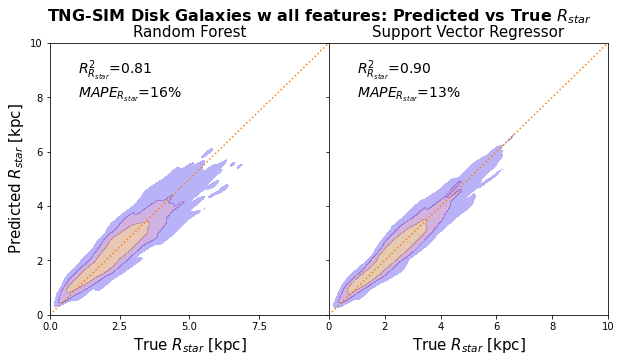

In [19]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle(r'TNG-SIM Disk Galaxies w all features: Predicted vs True $R_{star}$ ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = (r'$R^{2}$={}' + '\n' + r'$MAPE_{Rstar}$={}$\%$'.format(r2_RF_dm, mape_RF_dm))
# label = r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im1 = ax1.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_dm), 
#                     s=3, marker='.', alpha=0.7, label=label) # , vmin=-2, vmax=1.0)

im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_RF', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax1, fill=True, cmap='brg') #,
#                  legend = r'$R^{2}_{R_{star}}$=0.85'+'\n'+r'$MAPE_{R_{star}}$=12$\%$')
# ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([0.0, 2.5, 5.0, 7.5]) #, 10.0 ]) #, 12.5, 15.0, 17.5])
# ax1.set_ylim([-0.5,2.0])
ax1.axis([0.0,10.0, 0.0,10.0])
ax1.set_title('Random Forest', fontsize=15)
ax1.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax1.set_ylabel(r'Predicted $R_{star}$ [kpc]', fontsize=15)
ax1.annotate(r'$R^{2}_{R_{star}}$=0.81'+'\n'+r'$MAPE_{R_{star}}$=16$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax1.legend(loc='upper left', shadow=True)
ax1.plot([0, 30], [0, 30],linestyle='dotted')

# label = r'$R^{2}_{R_{star}}$=0.67'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im2 = ax2.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_dm), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_SVR', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax2, fill=True, cmap='brg') #,
#                  label = label, legend=True)
# ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.axis([0.0,10.0, 0.0,10.0])
ax2.set_title('Support Vector Regressor', fontsize=15)
ax2.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax2.annotate(r'$R^{2}_{R_{star}}$=0.90'+'\n'+r'$MAPE_{R_{star}}$=13$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax2.set_ylabel(r'Predicted $R_{star}$ [kpc]')
# ax2.legend(loc='upper left' , shadow=True)
ax2.plot([0, 30], [0, 30],linestyle='dotted')

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v26_fig_RF_SVR_allfeatures/v26_Disks_allfeatures_TNG-SIM_RF_SVR_pred_true_KDE.pdf", dpi=500)
plt.show()

### <font color='purple'> <a id =10> </a> <br> Disks 0D+Mvir Dataset w all features

In [5]:
# RF and SVR predicted log10Rstar


y_pred_RF_all_0D = pd.read_csv('TNG-SIM_images/v23a_Disks_RF_FeatRank_0DwMvir/v23a_Disks_TNG-SIM_0DwMvir_y_pred_RF_predicted_sizes.csv')

y_pred_SVR_all_0D = pd.read_csv('TNG-SIM_images/v24a_Disks_SVR_0DwMvir/v24a_Disks_TNG-SIM_0DwMvir_y_pred_SVR_predicted_sizes.csv')

# Solving the indexing problem of the two dataframes
y_pred_RF_all_0D_copy = y_pred_RF_all_0D.copy()

df_disks_copy = df_disks_original.copy()

df_disks_copy.reset_index(inplace=True)

y_pred_RF_all_0D_copy.reset_index(inplace=True)

y_pred_SVR_all_0D_copy = y_pred_SVR_all_0D.copy()
y_pred_SVR_all_0D_copy.reset_index(inplace=True)

# RF and SVR predicted Rstar, and true Rstar

y_pred_RF = (10**(y_pred_RF_all_0D_copy.loc[:, 'y_pred_RF SIM 0D Disks']- 1.e-8))*df_disks_copy.loc[:, 'Group_R_TopHat200']
y_true = df_disks_original.loc[:, 'SubhaloRstar']
print(y_pred_RF.shape)
print(y_true.shape)

y_pred_SVR = (10**(y_pred_SVR_all_0D_copy.loc[:, 'y_pred_SVR SIM 0D Disks']- 1.e-8))*df_disks_copy.loc[:, 'Group_R_TopHat200']
print(y_pred_SVR.shape)

(3215,)
(3215,)
(3215,)


In [6]:
# Make a df with pred_true values to use w seaborn

df_pred_true = pd.DataFrame({'y_pred_RF' : y_pred_RF, 
                             'y_pred_SVR': y_pred_SVR,
                             'y_true' : df_disks_original.loc[:, 'SubhaloRstar']})

In [7]:
r2_RF_all = np.round(r2_score(y_true, y_pred_RF), 2)
print('r2 RF ', r2_RF_all)
r2_SVR_all = np.round(r2_score(y_true, y_pred_SVR), 2)
print('r2 SVR ', r2_SVR_all)
mape_RF_all = mean_absolute_percentage_error(y_true, y_pred_RF)
mape_SVR_all = mean_absolute_percentage_error(y_true, y_pred_SVR)
print('mape RF', mape_RF_all )
print('mape SVR', mape_SVR_all )

r2 RF  0.81
r2 SVR  0.9
mape RF 0.1645414921395256
mape SVR 0.12780867671717708


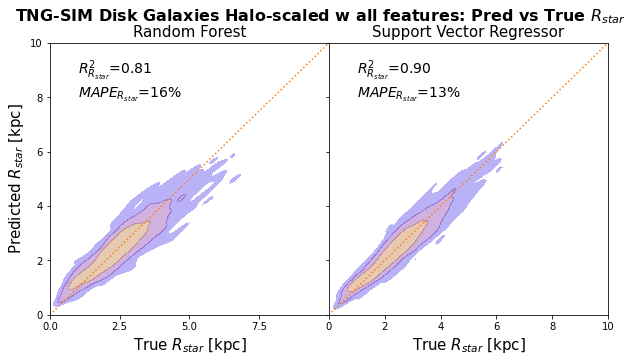

In [14]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle(r'TNG-SIM Disk Galaxies Halo-scaled w all features: Pred vs True $R_{star}$ ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

# label = (r'$R^{2}$={}' + '\n' + r'$MAPE_{Rstar}$={}$\%$'.format(r2_RF_dm, mape_RF_dm))
# label = r'$R^{2}_{R_{star}}$=0.66'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im1 = ax1.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_dm), 
#                     s=3, marker='.', alpha=0.7, label=label) # , vmin=-2, vmax=1.0)

im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_RF', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax1, fill=True, cmap='brg') #,
#                  legend = r'$R^{2}_{R_{star}}$=0.69'+'\n'+r'$MAPE_{R_{star}}$=29$\%$')
# ax1.set_xlim([8.0, 11.5])
ax1.set_xticks([0.0, 2.5, 5.0, 7.5]) #, 10.0 ]) #, 12.5, 15.0, 17.5])
# ax1.set_ylim([-0.5,2.0])
ax1.axis([0.0,10.0, 0.0,10.0])
ax1.set_title('Random Forest', fontsize=15)
ax1.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax1.set_ylabel(r'Predicted $R_{star}$ [kpc]', fontsize=15)
ax1.annotate(r'$R^{2}_{R_{star}}$=0.81'+'\n'+r'$MAPE_{R_{star}}$=16$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax1.legend(loc='upper left', shadow=True)
ax1.plot([0, 30], [0, 30],linestyle='dotted')

# label = r'$R^{2}_{R_{star}}$=0.67'+'\n'+r'$MAPE_{R_{star}}$=29$\%$'
# im2 = ax2.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_SVR_dm), 
#                      s=3, marker='.', alpha=0.7,label= label) #, vmin=-2, vmax=1.0)
im1 = sns.kdeplot(data= df_pred_true, x='y_true', y = 'y_pred_SVR', alpha=0.3, gridsize=200, bw_adjust=0.5,
            levels = [0.1,0.25,0.5,1.0], ax = ax2, fill=True, cmap='brg') #,
#                  label = label, legend=True)
# ax2.set_xlim([0.0,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.axis([0.0,10.0, 0.0,10.0])
ax2.set_title('Support Vector Regressor', fontsize=15)
ax2.set_xlabel(r'True $R_{star}$ [kpc]', fontsize=15)
ax2.annotate(r'$R^{2}_{R_{star}}$=0.90'+'\n'+r'$MAPE_{R_{star}}$=13$\%$', (0.1,0.8), xycoords='axes fraction', size=14)
# ax2.set_ylabel(r'Predicted $R_{star}$ [kpc]')
# ax2.legend(loc='upper left' , shadow=True)
ax2.plot([0, 30], [0, 30],linestyle='dotted')

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG-SIM_images/v26_fig_RF_SVR_allfeatures/v26_Disks_allfeatures0DwMvir_TNG-SIM_RF_SVR_pred_true_KDE.pdf", dpi=500)
plt.show()

## <font color='purple'> <a id =10> </a> <br> Feature names & Correlation Matrices

In [37]:
def translate_names(namelist,return_dictionary=False):
    '''translate to paper names'''
    feature_dict={'GroupSpin_dmo':'$\lambda$', # spin
        # metallicities, SFR, Nsubs
        'SubhaloGasMetallicity':'$Z_{gas}$',
        'SubhaloStarMetallicity':'$Z_{star}$',
        'SubhaloSFRinRad':'SFR', 'GroupNsubs' : '$N_{subs}$',
         # Galaxy Masses         
        'SubhaloBHMass':'$M_{BH}$', 'SubhaloBHMass_hs':'$M_{BH} / M_{vir}$',
        'SubhaloBHMdot':'$\dot{M}_{BH}$','SubhaloBHMdot_hs':'$\dot{M}_{BH} / M_{vir}$', 
        'SubhaloMstar':'$M_{star}$', 'SubhaloMstar_hs':'$M_{star} / M_{vir}$',
        'SubhaloMgas':'$M_{gas}$','SubhaloMgas_hs':'$M_{gas} / M_{vir}$',
        'SubhaloMHI':'$M_{HI}$','SubhaloMHI_hs':'$M_{HI} / M_{vir}$',
        'SubhaloMH2':'$M_{H2}$','SubhaloMH2_hs':'$M_{H2} / M_{vir}$',
         # Velocities         
        'SubhaloVelDisp':'$\sigma_V$','SubhaloVelDisp_hs':'$\sigma_V/V_{vir}$',
        'SubhaloVmax':'$V_{max}$', 'SubhaloVmax_hs':'$V_{max} / V_{vir}$',

        # Halo variables
        'Group_M_TopHat200':'$M_{vir}$','Group_V_TopHat200':'$V_{vir}$',
        'Group_R_TopHat200':'$R_{vir}$',
                  # Galaxy Sizes
                  'SubhaloRgas':'$R_{gas}$', 'SubhaloRgas_hs':'$R_{gas} / R_{vir}$',
                  'SubhaloVmaxRad':'$R_{Vmax}$', 'SubhaloVmaxRad_hs':'$R_{Vmax} / R_{vir}$',
                  'SubhaloRstar': '$R_{star}$', 'SubhaloRstar_hs':'$R_{star} / R_{vir}$'}
    if return_dictionary:
        print('njish')
        return feature_dict
    elif isinstance(namelist,str):
        print('dysh')

        return feature_dict(namelist)
    else:
        print('tresh')

        return [feature_dict[f] for f in namelist]

In [42]:
def figcorr(df, method='spearman', halo_scale=False):
        if halo_scale:
            df = df_0D
        corr = df.corr(method=method)
        c = (corr.sort_values(by='Group_M_TopHat200',axis=1)).sort_values(by='Group_M_TopHat200',axis=0)
        f,ax = plt.subplots(figsize=(15,12))
        fdict = translate_names(5,return_dictionary=True)
        print(c)
        c.rename(mapper=fdict,axis=0,inplace=True)
        c.rename(mapper=fdict,axis=1,inplace=True)
        sns.heatmap(c,ax=ax,cmap='GnBu',annot=True,vmax=1.0,vmin=-1.0,annot_kws={'fontsize':'xx-small'})
        ax.set_title( method +' correlation matrix')
#        plt.show()
#        plt.savefig(method[0]+'corr.pdf')
        return f

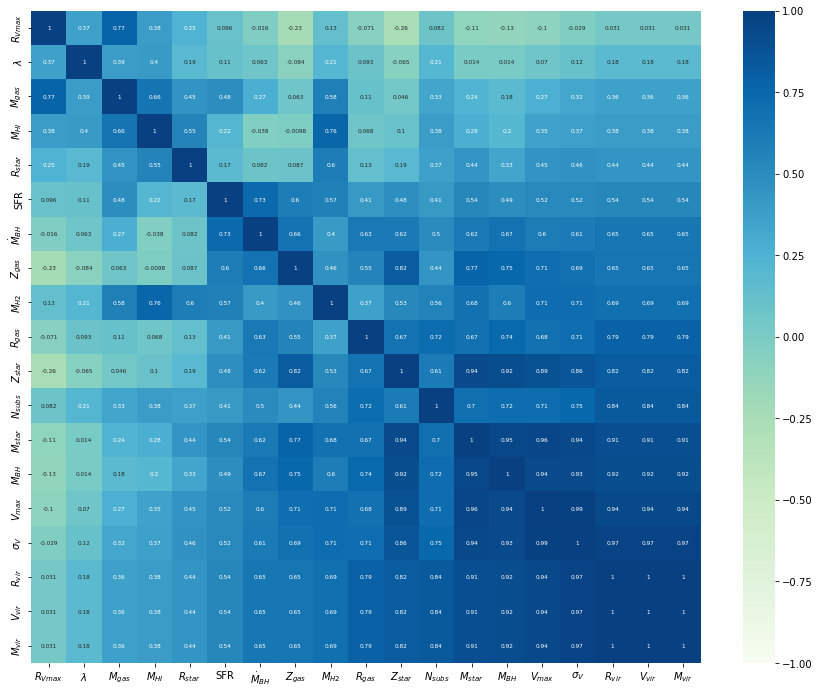

In [29]:
correlation_fig


In [23]:
# correlation_fig.savefig("TNG-SIM_images/v26_fig_RF_SVR_allfeatures/v26_Spearman_corr_matrix_Raw_notitle.pdf", dpi=500)

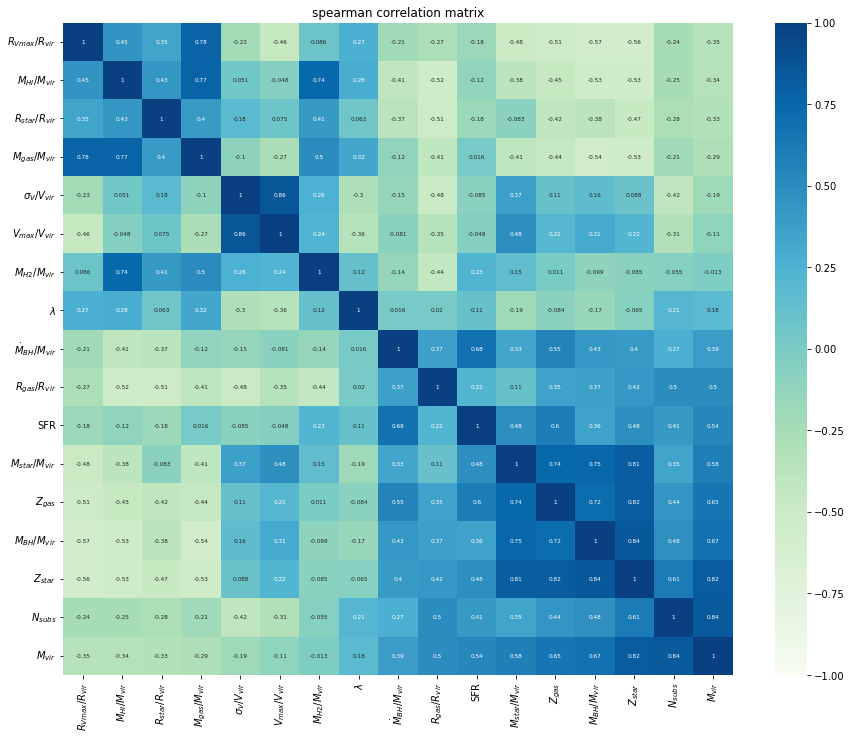

In [27]:
corr_fig_0D = figcorr(df_0D, halo_scale=True)

In [28]:
# corr_fig_0D.savefig("TNG-SIM_images/v26_fig_RF_SVR_allfeatures/v26_Spearman_corr_matrix_0D.pdf", dpi=500)